In [1]:
%load_ext autoreload
%autoreload 2

### 1. Load expression data

The `transformation` value can be one of `"none"`, `"sqrt"` or `"log"`, which determines how the expression data should be transformed in order to reduce outlier influence.

In [2]:
data_path = "data/Athaliana.csv"
transformation = "sqrt"

In [3]:
from my_gatai import Expression_data

expression_data = Expression_data.from_csv(data_path, 
                                           transformation=transformation)

#### 1.1 Compute TAI value

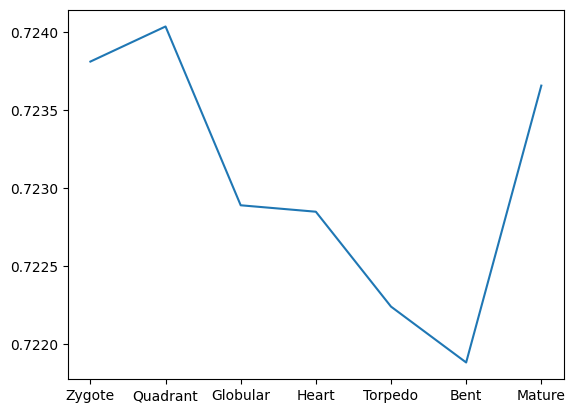

In [4]:
import matplotlib.pyplot as plt

plt.plot(expression_data.tai)
plt.show()

### 2. Flatline test

#### 2.1. Compute variance of TAI curve

In [5]:
import numpy as np
tai_var = np.var(expression_data.tai).item()
tai_var

5.704724792575682e-07

#### 2.2. Compute permutation variance distribution

Permute the assigned gene ages between the genes to run the flat line test

In [6]:
from gatai.utils import comp_vars

num_permutations = 10000
permutation_comp_vars = comp_vars(expression_data, num_permutations)

Running permuations


100%|██████████| 10000/10000 [00:04<00:00, 2193.35it/s]


#### 2.3. Fit the random variances to a Gamma distribution and compute the p-value of the true TAI

In [7]:
import scipy.stats as stats

# NOTE: the default fitting method used by scipy doesn't achieve a very good fit, so use "MM"
a, loc, scale = stats.gamma.fit(permutation_comp_vars, method="MM")
print(a, loc, scale)

0.7816116608716024 6.653681384843324e-09 3.389548082977427e-08


p-value

In [8]:
print(stats.gamma.sf(tai_var, a, loc=loc, scale=scale))

2.6915105268906236e-08


#### 2.4. Visually compare the random TAI variances against the true one

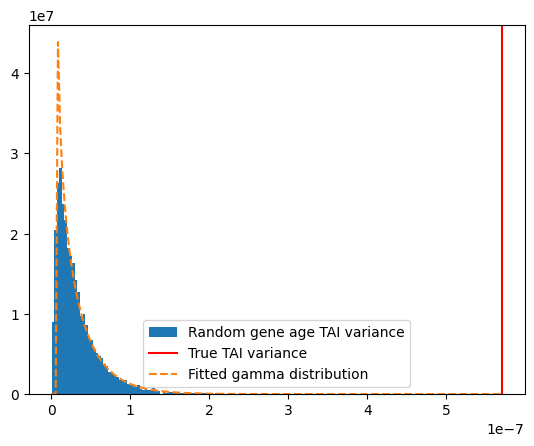

In [9]:
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")

x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")

plt.legend()
plt.show()

### 3. Destroy TAI signal with GATAI